In [1]:
import os
import cv2
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

# Converting image into grayscale

In [2]:
import os
from PIL import Image

def convert_images_to_bw(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)
        try:
            with Image.open(file_path) as img:
                bw_img = img.convert('L')
                bw_img.save(os.path.join(output_folder, filename))
                print(f"Converted {filename} to black and white.")
        except Exception as e:
            print(f"Could not process {filename}: {e}")


input_folder = r"C:\Users\dines\Desktop\dataset_two"
output_folder = r'C:\Users\dines\Desktop\input_gray' 

convert_images_to_bw(input_folder, output_folder)

Converted pinterest_259871840969966885.jpg to black and white.
Converted pinterest_259871840970151443.jpg to black and white.
Converted pinterest_259871840970193420.jpg to black and white.
Converted pinterest_259871840970216205.jpg to black and white.
Converted pinterest_259871840970276517.jpg to black and white.
Converted pinterest_259871840970338795.jpg to black and white.
Converted pinterest_259871840970612025.jpg to black and white.
Converted pinterest_259871840970612063.jpg to black and white.
Converted pinterest_259871840970612070.jpg to black and white.
Converted pinterest_259871840970612077.jpg to black and white.
Converted pinterest_259871840970618399.jpg to black and white.
Converted pinterest_259871840970623361.jpg to black and white.
Converted pinterest_259871840970627354.jpg to black and white.
Converted pinterest_259871840970627441.jpg to black and white.
Converted pinterest_259871840970671372.jpg to black and white.
Converted pinterest_259871840970671576.jpg to black and

In [3]:
def show_image(image):
    print("image colurized")
    # plt.imshow(cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_BGR2RGB))
    # plt.axis('off')
    # plt.show()


def save_processed_image( processed, title, output_folder):
    processed_save_path = os.path.join(output_folder, f"{title}")
    cv2.imwrite(processed_save_path, processed)

    print(f"Processed image saved at: {processed_save_path}")



def show_images_side_by_side(original, processed, title):
    print(f"Original: {original.shape}, Processed: {processed.shape}")
 
    # plt.figure(figsize=(10, 5))

   
    # plt.subplot(1, 2, 1)
    # plt.imshow(original, cmap='gray')
    # plt.title(f"Original - {title}")
    # plt.axis('off')  

    
    # plt.subplot(1, 2, 2)
    # plt.imshow(processed, cmap='gray')
    # plt.title(f"Bilateral Filtered - {title}")
    # plt.axis('off')  

    
    # plt.show()

In [4]:
import os
import requests
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import applications
from keras.models import load_model

BATCH_SIZE = 1

def download_file(url, save_path):
    response = requests.get(url)
    with open(save_path, 'wb') as file:
        file.write(response.content)

def setup_model():
    if not os.path.exists("MODEL"):
        os.makedirs("MODEL")
    model_path = "MODEL/my_model_colorization.h5"
    model_url = "http://dev.ipol.im/~lraad/chromaGAN/model/my_model_colorization.h5"
    if not os.path.isfile(model_path):
        print("Downloading the model...")
        download_file(model_url, model_path)
    else:
        print("Model already exists.")

class DATA():
    def __init__(self, dirname):
        self.dir_path = dirname
        self.filelist = [f for f in os.listdir(self.dir_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.batch_size = BATCH_SIZE
        self.size = len(self.filelist)
        self.data_index = 0

    def read_img(self, filename):
        IMAGE_SIZE = 224
        MAX_SIDE = 1500
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        if img is None:
            print(f"Unable to read image: {filename}")
            return False, None, None, None, None
        height, width, _ = img.shape
        if height > MAX_SIDE or width > MAX_SIDE:
            r = min(MAX_SIDE / height, MAX_SIDE / width)
            img = cv2.resize(img, (math.floor(width * r), math.floor(height * r)))
            print(f"Resized image to {img.shape[:2]}")
        labimg = cv2.cvtColor(cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)), cv2.COLOR_BGR2Lab)
        labimg_ori = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        return True, np.expand_dims(labimg[:, :, 0], axis=-1), labimg[:, :, 1:], img, np.expand_dims(labimg_ori[:, :, 0], axis=-1)

    def generate_batch(self):
        batch, labels, filelist, originalList, labimg_oritList = [], [], [], [], []
        for i in range(self.batch_size):
            filename = os.path.join(self.dir_path, self.filelist[self.data_index])
            ok, greyimg, colorimg, original, labimg_ori = self.read_img(filename)
            if ok:
                filelist.append(self.filelist[self.data_index])
                batch.append(greyimg)
                labels.append(colorimg)
                originalList.append(original)
                labimg_oritList.append(labimg_ori)
            self.data_index = (self.data_index + 1) % self.size
        return np.array(batch) / 255, np.array(labels) / 255, filelist, np.array(originalList), np.array(labimg_oritList) / 255

def deprocess(imgs):
    imgs = imgs * 255
    imgs = np.clip(imgs, 0, 255)
    return imgs.astype(np.uint8)

def reconstruct(batchX, predictedY):
    if batchX.shape[:2] != predictedY.shape[:2]:
        predictedY = cv2.resize(predictedY, (batchX.shape[1], batchX.shape[0]))
    result = np.concatenate((batchX, predictedY), axis=-1)
    return cv2.cvtColor(result, cv2.COLOR_Lab2BGR)



def sample_images(input_folder, output_folder):
    save_path = os.path.join("MODEL", "my_model_colorization.h5")
    colorizationModel = load_model(save_path)
    test_data = DATA(input_folder)

    if test_data.size == 0:
        raise ValueError("No images found in the input folder.")
    if BATCH_SIZE > test_data.size:
        raise ValueError("Batch size exceeds the number of images in the input folder.")

    total_batch = int(test_data.size / BATCH_SIZE)

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for b in range(total_batch):
        batchX, batchY, filelist, original, labimg_oritList = test_data.generate_batch()
        if batchX.any():
            predY, _ = colorizationModel.predict(np.tile(batchX, [1, 1, 1, 3]))
            for i in range(BATCH_SIZE):
                predY_2 = deprocess(predY[i])
                predResult_2 = reconstruct(deprocess(labimg_oritList[i]), predY_2)
                save_path = os.path.join(output_folder, filelist[i])
                cv2.imwrite(save_path, predResult_2)
                print(f"Saved colorized image to {save_path}")



Using TensorFlow backend.


In [5]:


def process_and_show_images(input_folder, output_folder,filtered):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

   
    for image_name in os.listdir(input_folder):
        input_path = os.path.join(input_folder, image_name)

        
        if os.path.isfile(input_path) and image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            print(f"Processing {image_name}...")

            
            image = cv2.imread(input_path)

            if image is None:
                print(f"Failed to load {image_name}")
                continue
            filtered_image = filtered(image)

            
            save_processed_image( filtered_image, image_name, output_folder)

            
            show_images_side_by_side(image, filtered_image, image_name)


In [6]:
# flip all images in the dataset
def only_flip(image):
    flipped_image = cv2.flip(image, 1)

    
    return flipped_image

input_folder = r'C:\Users\dines\Desktop\dataset_two' 
output_folder = r'C:\Users\dines\Desktop\dataset_two_flip' 

process_and_show_images(input_folder, output_folder,only_flip)


Processing pinterest_259871840969966885.jpg...
Processed image saved at: C:\Users\dines\Desktop\dataset_two_flip\pinterest_259871840969966885.jpg
Original: (357, 520, 3), Processed: (357, 520, 3)
Processing pinterest_259871840970151443.jpg...
Processed image saved at: C:\Users\dines\Desktop\dataset_two_flip\pinterest_259871840970151443.jpg
Original: (396, 291, 3), Processed: (396, 291, 3)
Processing pinterest_259871840970193420.jpg...
Processed image saved at: C:\Users\dines\Desktop\dataset_two_flip\pinterest_259871840970193420.jpg
Original: (450, 964, 3), Processed: (450, 964, 3)
Processing pinterest_259871840970216205.jpg...
Processed image saved at: C:\Users\dines\Desktop\dataset_two_flip\pinterest_259871840970216205.jpg
Original: (635, 634, 3), Processed: (635, 634, 3)
Processing pinterest_259871840970276517.jpg...
Processed image saved at: C:\Users\dines\Desktop\dataset_two_flip\pinterest_259871840970276517.jpg
Original: (500, 400, 3), Processed: (500, 400, 3)
Processing pinterest

# Applying filers to Grayscale images


In [7]:
def custom(image):
    flipped_image = cv2.flip(image, 1)
    gaussian_blur = cv2.GaussianBlur(flipped_image, (3, 3), 0)
    final_image = cv2.bilateralFilter(gaussian_blur, 5, 10, 10)

    
    return final_image


input_folder = r'C:\Users\dines\Desktop\input_gray' 
output_folder = r'C:\Users\dines\Desktop\custom_gray' 


process_and_show_images(input_folder, output_folder,custom)

Processing pinterest_259871840969966885.jpg...
Processed image saved at: C:\Users\dines\Desktop\custom_gray\pinterest_259871840969966885.jpg
Original: (357, 520, 3), Processed: (357, 520, 3)
Processing pinterest_259871840970151443.jpg...
Processed image saved at: C:\Users\dines\Desktop\custom_gray\pinterest_259871840970151443.jpg
Original: (396, 291, 3), Processed: (396, 291, 3)
Processing pinterest_259871840970193420.jpg...
Processed image saved at: C:\Users\dines\Desktop\custom_gray\pinterest_259871840970193420.jpg
Original: (450, 964, 3), Processed: (450, 964, 3)
Processing pinterest_259871840970216205.jpg...
Processed image saved at: C:\Users\dines\Desktop\custom_gray\pinterest_259871840970216205.jpg
Original: (635, 634, 3), Processed: (635, 634, 3)
Processing pinterest_259871840970276517.jpg...
Processed image saved at: C:\Users\dines\Desktop\custom_gray\pinterest_259871840970276517.jpg
Original: (500, 400, 3), Processed: (500, 400, 3)
Processing pinterest_259871840970338795.jpg..

In [8]:

def apply_bilateral_gaussian(image, d=5, sigma_color=10, sigma_space=10):

    gaussian_blur = cv2.GaussianBlur(image, (3, 3), 0)

    bilateral_image = cv2.bilateralFilter(gaussian_blur, d, sigma_color, sigma_space)
    

    return bilateral_image


input_folder = r'C:\Users\dines\Desktop\input_gray' 
output_folder = r'C:\Users\dines\Desktop\bilateral_gaussian_gray' 


process_and_show_images(input_folder, output_folder,apply_bilateral_gaussian)

Processing pinterest_259871840969966885.jpg...
Processed image saved at: C:\Users\dines\Desktop\bilateral_gaussian_gray\pinterest_259871840969966885.jpg
Original: (357, 520, 3), Processed: (357, 520, 3)
Processing pinterest_259871840970151443.jpg...
Processed image saved at: C:\Users\dines\Desktop\bilateral_gaussian_gray\pinterest_259871840970151443.jpg
Original: (396, 291, 3), Processed: (396, 291, 3)
Processing pinterest_259871840970193420.jpg...
Processed image saved at: C:\Users\dines\Desktop\bilateral_gaussian_gray\pinterest_259871840970193420.jpg
Original: (450, 964, 3), Processed: (450, 964, 3)
Processing pinterest_259871840970216205.jpg...
Processed image saved at: C:\Users\dines\Desktop\bilateral_gaussian_gray\pinterest_259871840970216205.jpg
Original: (635, 634, 3), Processed: (635, 634, 3)
Processing pinterest_259871840970276517.jpg...
Processed image saved at: C:\Users\dines\Desktop\bilateral_gaussian_gray\pinterest_259871840970276517.jpg
Original: (500, 400, 3), Processed:

# colourizing grayscale images


In [9]:
input_folder = r'C:\Users\dines\Desktop\input_gray' 
output_folder = r'C:\Users\dines\Desktop\input_color'
setup_model()
sample_images(input_folder, output_folder)

Model already exists.















Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




c:\Users\dines\Desktop\courseproject_it204\vs_code\myenv\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Saved colorized image to C:\Users\dines\Desktop\input_color\pinterest_259871840969966885.jpg
Saved colorized image to C:\Users\dines\Desktop\input_color\pinterest_259871840970151443.jpg
Saved colorized image to C:\Users\dines\Desktop\input_color\pinterest_259871840970193420.jpg
Saved colorized image to C:\Users\dines\Desktop\input_color\pinterest_259871840970216205.jpg
Saved colorized image to C:\Users\dines\Desktop\input_color\pinterest_259871840970276517.jpg
Resized image to (1500, 1003)
Saved colorized image to C:\Users\dines\Desktop\input_color\pinterest_259871840970338795.jpg
Saved colorized image to C:\Users\dines\Desktop\input_color\pinterest_259871840970612025.jpg
Saved colorized image to C:\Users\dines\Desktop\input_color\pinterest_259871840970612063.jpg
Saved colorized image to C:\Users\dines\Desktop\input_color\pinterest_259871840970612070.jpg
Saved colorized image to C:\Users\dines\Desktop\input_color\pinterest_259871840970612077.jpg
Saved colorized image to C:\Users\dines\

In [10]:
input_folder = r'C:\Users\dines\Desktop\custom_gray' 
output_folder = r'C:\Users\dines\Desktop\custom_colour' 
setup_model()
sample_images(input_folder, output_folder)

Model already exists.


c:\Users\dines\Desktop\courseproject_it204\vs_code\myenv\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Saved colorized image to C:\Users\dines\Desktop\custom_colour\pinterest_259871840969966885.jpg
Saved colorized image to C:\Users\dines\Desktop\custom_colour\pinterest_259871840970151443.jpg
Saved colorized image to C:\Users\dines\Desktop\custom_colour\pinterest_259871840970193420.jpg
Saved colorized image to C:\Users\dines\Desktop\custom_colour\pinterest_259871840970216205.jpg
Saved colorized image to C:\Users\dines\Desktop\custom_colour\pinterest_259871840970276517.jpg
Resized image to (1500, 1003)
Saved colorized image to C:\Users\dines\Desktop\custom_colour\pinterest_259871840970338795.jpg
Saved colorized image to C:\Users\dines\Desktop\custom_colour\pinterest_259871840970612025.jpg
Saved colorized image to C:\Users\dines\Desktop\custom_colour\pinterest_259871840970612063.jpg
Saved colorized image to C:\Users\dines\Desktop\custom_colour\pinterest_259871840970612070.jpg
Saved colorized image to C:\Users\dines\Desktop\custom_colour\pinterest_259871840970612077.jpg
Saved colorized imag

In [11]:
input_folder = r'C:\Users\dines\Desktop\bilateral_gaussian_gray' 
output_folder = r'C:\Users\dines\Desktop\bilateral_gaussian_color'
setup_model()
sample_images(input_folder, output_folder)

Model already exists.


c:\Users\dines\Desktop\courseproject_it204\vs_code\myenv\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Saved colorized image to C:\Users\dines\Desktop\bilateral_gaussian_color\pinterest_259871840969966885.jpg
Saved colorized image to C:\Users\dines\Desktop\bilateral_gaussian_color\pinterest_259871840970151443.jpg
Saved colorized image to C:\Users\dines\Desktop\bilateral_gaussian_color\pinterest_259871840970193420.jpg
Saved colorized image to C:\Users\dines\Desktop\bilateral_gaussian_color\pinterest_259871840970216205.jpg
Saved colorized image to C:\Users\dines\Desktop\bilateral_gaussian_color\pinterest_259871840970276517.jpg
Resized image to (1500, 1003)
Saved colorized image to C:\Users\dines\Desktop\bilateral_gaussian_color\pinterest_259871840970338795.jpg
Saved colorized image to C:\Users\dines\Desktop\bilateral_gaussian_color\pinterest_259871840970612025.jpg
Saved colorized image to C:\Users\dines\Desktop\bilateral_gaussian_color\pinterest_259871840970612063.jpg
Saved colorized image to C:\Users\dines\Desktop\bilateral_gaussian_color\pinterest_259871840970612070.jpg
Saved colorized 

# Plotting the results

In [12]:
# Function to calculate PSNR
def calculate_psnr(original, processed):
    mse = ((original - processed) ** 2).mean()
    if mse == 0:  # MSE is zero means no noise in the signal
        return 100
    max_pixel = 255.0
    psnr_value = 20 * log10(max_pixel / sqrt(mse))
    return psnr_value


In [13]:
def analyze(original_dir,original_dir_flip,  input_colour_dir, bilateral_gaussian_dir, flip_bilateral_gaussian_dir, output_csv_path,img_psnr_path,img_ssim_path):
    directories = [original_dir, original_dir_flip, input_colour_dir,bilateral_gaussian_dir,flip_bilateral_gaussian_dir ]
    for dir_path in directories:
        if not os.path.isdir(dir_path):
            print(f"Directory does not exist: {dir_path}")
            exit(1)
    
    # Prepare DataFrame to store the results
    columns = [
        'Image', 
        'SSIM_Input_Colour', 'PSNR_Input_Colour', 
        'SSIM_Bilateral_Gaussian', 'PSNR_Bilateral_Gaussian',
        'SSIM_Flip_Bilateral_Gaussian', 'PSNR_Flip_Bilateral_Gaussian',
        
    ]
    results = []
    
    # Get the list of images
    original_images = sorted(os.listdir(original_dir))
    print(f"Number of original images found: {len(original_images)}")
    
    # Function to check if file is an image based on extension
    def is_image_file(filename):
        image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff']
        return any(filename.lower().endswith(ext) for ext in image_extensions)
    
    original_images = [img for img in original_images if is_image_file(img)]
    print(f"Number of image files after filtering: {len(original_images)}\n")
    
    # Loop through the images and calculate SSIM and PSNR
    for idx, img_name in enumerate(original_images, 1):
        print(f"Processing image {idx}/{len(original_images)}: {img_name}")
        
        # Read original image
        original_img_path = os.path.join(original_dir, img_name)
        original_img = cv2.imread(original_img_path)
        flip_img=cv2.imread(os.path.join(original_dir_flip, img_name))
        
        if original_img is None:
            print(f"  [Error] Failed to read original image: {original_img_path}")
            continue
        
        
        
        # Initialize a dictionary to hold processed images
        processed_images = {}
        processed_dirs = {
            'Input_Colour': input_colour_dir,
            'bilateral_gaussian': bilateral_gaussian_dir,
            'flip_bilateral_gaussian': flip_bilateral_gaussian_dir
        }
    
        skip_image = False
        for key, proc_dir in processed_dirs.items():
            proc_img_path = os.path.join(proc_dir, img_name)
            processed_img = cv2.imread(proc_img_path)
            if processed_img is None:
                print(f"  [Error] Failed to read {key} image: {proc_img_path}")
                skip_image = True
                break
            processed_images[key] = processed_img
    
        if skip_image:
            print(f"  [Skipped] Missing or unreadable processed images for: {img_name}\n")
            continue
        
        # Calculate SSIM
        try:
            ssim_input_colour = ssim(original_img, processed_images['Input_Colour'], multichannel=True)
            ssim_bilateral_gaussian = ssim(original_img, processed_images['bilateral_gaussian'], multichannel=True)
            ssim_flip_bilateral_gaussian = ssim(flip_img, processed_images['flip_bilateral_gaussian'], multichannel=True)
    
        except Exception as e:
            print(f"  [Error] Calculating SSIM for {img_name}: {e}")
            continue
        
        # Calculate PSNR
        try:
            psnr_input_colour = calculate_psnr(original_img, processed_images['Input_Colour'])
            psnr_bilateral_gaussian = calculate_psnr(original_img, processed_images['bilateral_gaussian'])
            psnr_flip_bilateral_gaussian = calculate_psnr(flip_img, processed_images['flip_bilateral_gaussian'])
    
        except Exception as e:
            print(f"  [Error] Calculating PSNR for {img_name}: {e}")
            continue
        
        # Append the results
        results.append([
            img_name, 
            ssim_input_colour, psnr_input_colour, 
            ssim_bilateral_gaussian, psnr_bilateral_gaussian,
            ssim_flip_bilateral_gaussian, psnr_flip_bilateral_gaussian
        ])
        print(f"  [Success] Calculated SSIM and PSNR for: {img_name}\n")
    
    # Check if results were collected
    if not results:
        print("No SSIM or PSNR values were calculated. Please check the image paths and filenames.")
        exit(1)
    
    # Create DataFrame
    df = pd.DataFrame(results, columns=columns)
    
    # Calculate average SSIM and PSNR for each processing method
    average_row = {
        'Image': 'Average',
        'SSIM_Input_Colour': df['SSIM_Input_Colour'].mean(),
        'PSNR_Input_Colour': df['PSNR_Input_Colour'].mean(),
        'SSIM_Bilateral_Gaussian': df['SSIM_Bilateral_Gaussian'].mean(),
        'PSNR_Bilateral_Gaussian': df['PSNR_Bilateral_Gaussian'].mean(),
        'SSIM_Flip_Bilateral_Gaussian': df['SSIM_Flip_Bilateral_Gaussian'].mean(),
        'PSNR_Flip_Bilateral_Gaussian': df['PSNR_Flip_Bilateral_Gaussian'].mean()
    }
    
    # Append the average row to the DataFrame
    df = df.append(average_row, ignore_index=True)
    
    
    try:
        df.to_csv(output_csv_path, index=False)
        print(f"SSIM and PSNR values saved to {output_csv_path}")
    except Exception as e:
        print(f"Failed to save CSV: {e}")
        exit(1)
    
    # Visualization
    # Remove the 'Average' row for plotting
    df_plot = df[df['Image'] != 'Average']
    
    # Melt the DataFrame to a long format for easier plotting
    ssim_columns = ['SSIM_Input_Colour', 'SSIM_Bilateral_Gaussian', 'SSIM_Flip_Bilateral_Gaussian']
    psnr_columns = ['PSNR_Input_Colour', 'PSNR_Bilateral_Gaussian', 'PSNR_Flip_Bilateral_Gaussian']
    
    # Extract method names
    methods = ['Input Colour', 'Bilateral Filter - Gaussian', 'Flip Bilateral Filter - Gaussian']
    
    # Calculate average values (excluding 'Average' row)
    average_values = {
        'SSIM_Input_Colour': df_plot['SSIM_Input_Colour'].mean(),
        'PSNR_Input_Colour': df_plot['PSNR_Input_Colour'].mean(),
        'SSIM_Bilateral_Gaussian': df_plot['SSIM_Bilateral_Gaussian'].mean(),
        'PSNR_Bilateral_Gaussian': df_plot['PSNR_Bilateral_Gaussian'].mean(),
        'SSIM_Flip_Bilateral_Gaussian': df_plot['SSIM_Flip_Bilateral_Gaussian'].mean(),
        'PSNR_Flip_Bilateral_Gaussian': df_plot['PSNR_Flip_Bilateral_Gaussian'].mean()
    
    }
    
    # Plot SSIM
    plt.figure(figsize=(10, 6))
    ssim_means = [average_values['SSIM_Input_Colour'], average_values['SSIM_Bilateral_Gaussian'], average_values['SSIM_Flip_Bilateral_Gaussian']]
    sns.barplot(x=methods, y=ssim_means, palette='viridis')
    plt.title('Average SSIM Values by Processing Method')
    plt.ylabel('SSIM')
    plt.ylim(0, 1)  # SSIM ranges from 0 to 1
    for index, value in enumerate(ssim_means):
        plt.text(index, value + 0.01, f"{value:.4f}", ha='center')
    plt.tight_layout()
    plt.savefig(img_ssim_path)
    plt.show()
    
    # Plot PSNR
    plt.figure(figsize=(10, 6))
    psnr_means = [average_values['PSNR_Input_Colour'], 
                 average_values['PSNR_Bilateral_Gaussian'], average_values['PSNR_Flip_Bilateral_Gaussian']]
    sns.barplot(x=methods, y=psnr_means, palette='magma')
    plt.title('Average PSNR Values by Processing Method')
    plt.ylabel('PSNR (dB)')
    for index, value in enumerate(psnr_means):
        plt.text(index, value + 0.5, f"{value:.2f}", ha='center')
    plt.tight_layout()
    plt.savefig(img_psnr_path)
    plt.show()
        

Number of original images found: 1163
Number of image files after filtering: 1157

Processing image 1/1157: pinterest_259871840969966885.jpg
  [Success] Calculated SSIM and PSNR for: pinterest_259871840969966885.jpg

Processing image 2/1157: pinterest_259871840970151443.jpg
  [Success] Calculated SSIM and PSNR for: pinterest_259871840970151443.jpg

Processing image 3/1157: pinterest_259871840970193420.jpg
  [Success] Calculated SSIM and PSNR for: pinterest_259871840970193420.jpg

Processing image 4/1157: pinterest_259871840970216205.jpg
  [Success] Calculated SSIM and PSNR for: pinterest_259871840970216205.jpg

Processing image 5/1157: pinterest_259871840970276517.jpg
  [Success] Calculated SSIM and PSNR for: pinterest_259871840970276517.jpg

Processing image 6/1157: pinterest_259871840970338795.jpg
  [Error] Calculating SSIM for pinterest_259871840970338795.jpg: Input images must have the same dimensions.
Processing image 7/1157: pinterest_259871840970612025.jpg
  [Success] Calculated

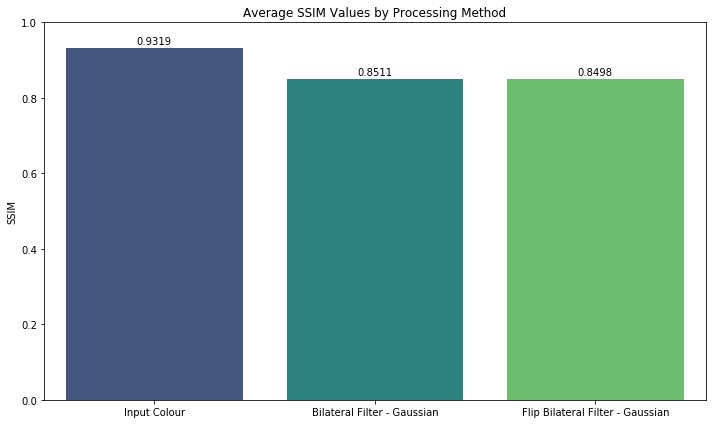

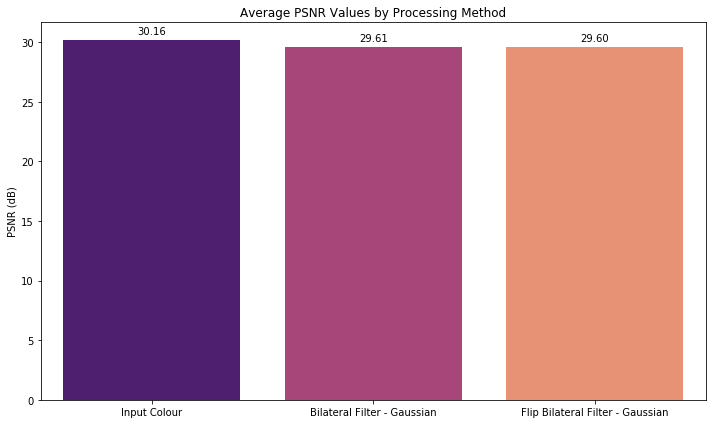

In [14]:
original_dir = r'C:\Users\dines\Desktop\dataset_two' 
original_dir_flip = r'C:\Users\dines\Desktop\dataset_two_flip' 
input_colour_dir = r"C:\Users\dines\Desktop\input_color"
bilateral_gaussian_dir=r"C:\Users\dines\Desktop\bilateral_gaussian_color"
flip_bilateral_gaussian_dir=r"C:\Users\dines\Desktop\custom_colour"
output_csv_path = r"C:\Users\dines\Desktop\p_1_comparison_results.csv"
img_psnr=r"C:\Users\dines\Desktop\p_1_average_psnr.png"
img_ssim=r"C:\Users\dines\Desktop\p_1_average_ssim.png"

analyze(original_dir, original_dir_flip, input_colour_dir, bilateral_gaussian_dir, flip_bilateral_gaussian_dir, output_csv_path, img_psnr, img_ssim)


In [32]:
output_csv_path = r"C:\Users\dines\Desktop\p_1_comparison_results.csv"

In [33]:
import pandas as pd

data = pd.read_csv(output_csv_path)

print("Image Comparison Results:")
print(data.to_string(index=False))


Image Comparison Results:
                            Image  SSIM_Input_Colour  PSNR_Input_Colour  SSIM_Bilateral_Gaussian  PSNR_Bilateral_Gaussian  SSIM_Flip_Bilateral_Gaussian  PSNR_Flip_Bilateral_Gaussian
 pinterest_259871840969966885.jpg           0.954950          31.294467                 0.832834                30.045889                      0.835293                     30.067042
 pinterest_259871840970151443.jpg           0.973360          34.216035                 0.899435                31.209811                      0.886304                     29.739578
 pinterest_259871840970193420.jpg           0.905668          28.961562                 0.695818                28.538087                      0.700081                     28.574563
 pinterest_259871840970216205.jpg           0.839131          29.551004                 0.711619                28.923012                      0.711112                     28.907613
 pinterest_259871840970276517.jpg           0.915549          28

# For the Mini_dataset

In [15]:
# convert the original images into grayscale

input_folder = r"C:\Users\dines\Desktop\dataset_one"
output_folder = r'C:\Users\dines\Desktop\small_set_gray' 

convert_images_to_bw(input_folder, output_folder)

Converted old_photo_01.jpg to black and white.
Converted old_photo_02.jpg to black and white.
Converted old_photo_03.jpg to black and white.
Converted old_photo_04.jpg to black and white.
Converted old_photo_05.jpg to black and white.
Converted old_photo_06.jpg to black and white.
Converted old_photo_07.jpg to black and white.
Converted old_photo_08.jpeg to black and white.
Converted old_photo_09.jpeg to black and white.
Converted old_photo_10.jpg to black and white.
Converted old_photo_11.jpg to black and white.
Converted old_photo_12.jpg to black and white.
Converted old_photo_13.jpg to black and white.
Converted old_photo_14.jpg to black and white.
Converted old_photo_15.jpg to black and white.
Converted old_photo_16.jpg to black and white.
Converted old_photo_18.jpg to black and white.
Converted old_photo_19.jpg to black and white.
Converted old_photo_20.jpg to black and white.
Converted old_photo_21.jpg to black and white.
Converted old_photo_22.jpg to black and white.
Converted o

In [16]:
# flipping the original image for comparing with the flipped outputs

input_folder = r"C:\Users\dines\Desktop\dataset_one"
output_folder = r"C:\Users\dines\Desktop\dataset_one_flip"

process_and_show_images(input_folder, output_folder,only_flip)

Processing old_photo_01.jpg...
Processed image saved at: C:\Users\dines\Desktop\dataset_one_flip\old_photo_01.jpg
Original: (1187, 800, 3), Processed: (1187, 800, 3)
Processing old_photo_02.jpg...
Processed image saved at: C:\Users\dines\Desktop\dataset_one_flip\old_photo_02.jpg
Original: (1200, 900, 3), Processed: (1200, 900, 3)
Processing old_photo_03.jpg...
Processed image saved at: C:\Users\dines\Desktop\dataset_one_flip\old_photo_03.jpg
Original: (512, 512, 3), Processed: (512, 512, 3)
Processing old_photo_04.jpg...
Processed image saved at: C:\Users\dines\Desktop\dataset_one_flip\old_photo_04.jpg
Original: (512, 512, 3), Processed: (512, 512, 3)
Processing old_photo_05.jpg...
Processed image saved at: C:\Users\dines\Desktop\dataset_one_flip\old_photo_05.jpg
Original: (400, 294, 3), Processed: (400, 294, 3)
Processing old_photo_06.jpg...
Processed image saved at: C:\Users\dines\Desktop\dataset_one_flip\old_photo_06.jpg
Original: (640, 422, 3), Processed: (640, 422, 3)
Processing o

In [17]:
# colourizing the grayscale images directly using CHROMAGAN

input_folder = r'C:\Users\dines\Desktop\small_set_gray'
output_folder = r'C:\Users\dines\Desktop\small_set_colour'
setup_model()
sample_images(input_folder, output_folder)

Model already exists.


c:\Users\dines\Desktop\courseproject_it204\vs_code\myenv\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Saved colorized image to C:\Users\dines\Desktop\small_set_colour\old_photo_01.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_colour\old_photo_02.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_colour\old_photo_03.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_colour\old_photo_04.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_colour\old_photo_05.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_colour\old_photo_06.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_colour\old_photo_07.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_colour\old_photo_08.jpeg
Saved colorized image to C:\Users\dines\Desktop\small_set_colour\old_photo_09.jpeg
Saved colorized image to C:\Users\dines\Desktop\small_set_colour\old_photo_10.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_colour\old_photo_11.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_colour\old_photo_12.jpg
Saved colorize

In [18]:
# Applying gaussian+bilateral filters to the grayscale images

input_folder = r'C:\Users\dines\Desktop\small_set_gray' 
output_folder = r'C:\Users\dines\Desktop\small_set_bilateral_gaussian_gray' 


process_and_show_images(input_folder, output_folder,apply_bilateral_gaussian)

Processing old_photo_01.jpg...
Processed image saved at: C:\Users\dines\Desktop\small_set_bilateral_gaussian_gray\old_photo_01.jpg
Original: (1187, 800, 3), Processed: (1187, 800, 3)
Processing old_photo_02.jpg...
Processed image saved at: C:\Users\dines\Desktop\small_set_bilateral_gaussian_gray\old_photo_02.jpg
Original: (1200, 900, 3), Processed: (1200, 900, 3)
Processing old_photo_03.jpg...
Processed image saved at: C:\Users\dines\Desktop\small_set_bilateral_gaussian_gray\old_photo_03.jpg
Original: (512, 512, 3), Processed: (512, 512, 3)
Processing old_photo_04.jpg...
Processed image saved at: C:\Users\dines\Desktop\small_set_bilateral_gaussian_gray\old_photo_04.jpg
Original: (512, 512, 3), Processed: (512, 512, 3)
Processing old_photo_05.jpg...
Processed image saved at: C:\Users\dines\Desktop\small_set_bilateral_gaussian_gray\old_photo_05.jpg
Original: (400, 294, 3), Processed: (400, 294, 3)
Processing old_photo_06.jpg...
Processed image saved at: C:\Users\dines\Desktop\small_set_b

In [19]:
# Colourizing the gaussian+bilateral filtered grayscale images

input_folder = r'C:\Users\dines\Desktop\small_set_bilateral_gaussian_gray' 
output_folder = r'C:\Users\dines\Desktop\small_set_bilateral_gaussian_color'
setup_model()
sample_images(input_folder, output_folder)

Model already exists.


c:\Users\dines\Desktop\courseproject_it204\vs_code\myenv\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Saved colorized image to C:\Users\dines\Desktop\small_set_bilateral_gaussian_color\old_photo_01.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_bilateral_gaussian_color\old_photo_02.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_bilateral_gaussian_color\old_photo_03.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_bilateral_gaussian_color\old_photo_04.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_bilateral_gaussian_color\old_photo_05.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_bilateral_gaussian_color\old_photo_06.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_bilateral_gaussian_color\old_photo_07.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_bilateral_gaussian_color\old_photo_08.jpeg
Saved colorized image to C:\Users\dines\Desktop\small_set_bilateral_gaussian_color\old_photo_09.jpeg
Saved colorized image to C:\Users\dines\Desktop\small_set_bilateral_gaussian_color\old_photo_10.jp

In [20]:
# Applying horizontal flip and then applying the gaussian +bilateral filter

input_folder = r'C:\Users\dines\Desktop\small_set_gray' 
output_folder = r'C:\Users\dines\Desktop\small_set_custom_gray' 


process_and_show_images(input_folder, output_folder,custom)

Processing old_photo_01.jpg...
Processed image saved at: C:\Users\dines\Desktop\small_set_custom_gray\old_photo_01.jpg
Original: (1187, 800, 3), Processed: (1187, 800, 3)
Processing old_photo_02.jpg...
Processed image saved at: C:\Users\dines\Desktop\small_set_custom_gray\old_photo_02.jpg
Original: (1200, 900, 3), Processed: (1200, 900, 3)
Processing old_photo_03.jpg...
Processed image saved at: C:\Users\dines\Desktop\small_set_custom_gray\old_photo_03.jpg
Original: (512, 512, 3), Processed: (512, 512, 3)
Processing old_photo_04.jpg...
Processed image saved at: C:\Users\dines\Desktop\small_set_custom_gray\old_photo_04.jpg
Original: (512, 512, 3), Processed: (512, 512, 3)
Processing old_photo_05.jpg...
Processed image saved at: C:\Users\dines\Desktop\small_set_custom_gray\old_photo_05.jpg
Original: (400, 294, 3), Processed: (400, 294, 3)
Processing old_photo_06.jpg...
Processed image saved at: C:\Users\dines\Desktop\small_set_custom_gray\old_photo_06.jpg
Original: (640, 422, 3), Process

In [21]:
# Colourizing the processed image

input_folder = r'C:\Users\dines\Desktop\small_set_custom_gray'
output_folder = r'C:\Users\dines\Desktop\small_set_custom_colour'
setup_model()
sample_images(input_folder, output_folder)

Model already exists.


c:\Users\dines\Desktop\courseproject_it204\vs_code\myenv\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


Saved colorized image to C:\Users\dines\Desktop\small_set_custom_colour\old_photo_01.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_custom_colour\old_photo_02.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_custom_colour\old_photo_03.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_custom_colour\old_photo_04.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_custom_colour\old_photo_05.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_custom_colour\old_photo_06.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_custom_colour\old_photo_07.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_custom_colour\old_photo_08.jpeg
Saved colorized image to C:\Users\dines\Desktop\small_set_custom_colour\old_photo_09.jpeg
Saved colorized image to C:\Users\dines\Desktop\small_set_custom_colour\old_photo_10.jpg
Saved colorized image to C:\Users\dines\Desktop\small_set_custom_colour\old_photo_11.jpg
Saved colorized ima

Number of original images found: 29
Number of image files after filtering: 29

Processing image 1/29: old_photo_01.jpg
  [Success] Calculated SSIM and PSNR for: old_photo_01.jpg

Processing image 2/29: old_photo_02.jpg
  [Success] Calculated SSIM and PSNR for: old_photo_02.jpg

Processing image 3/29: old_photo_03.jpg
  [Success] Calculated SSIM and PSNR for: old_photo_03.jpg

Processing image 4/29: old_photo_04.jpg
  [Success] Calculated SSIM and PSNR for: old_photo_04.jpg

Processing image 5/29: old_photo_05.jpg
  [Success] Calculated SSIM and PSNR for: old_photo_05.jpg

Processing image 6/29: old_photo_06.jpg
  [Success] Calculated SSIM and PSNR for: old_photo_06.jpg

Processing image 7/29: old_photo_07.jpg
  [Success] Calculated SSIM and PSNR for: old_photo_07.jpg

Processing image 8/29: old_photo_08.jpeg
  [Success] Calculated SSIM and PSNR for: old_photo_08.jpeg

Processing image 9/29: old_photo_09.jpeg
  [Success] Calculated SSIM and PSNR for: old_photo_09.jpeg

Processing image 

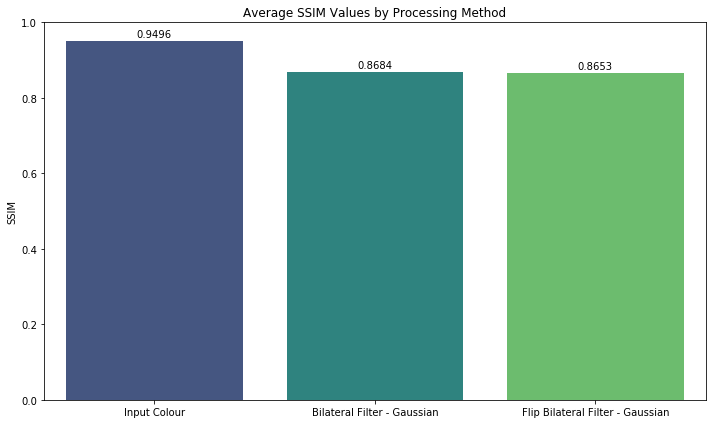

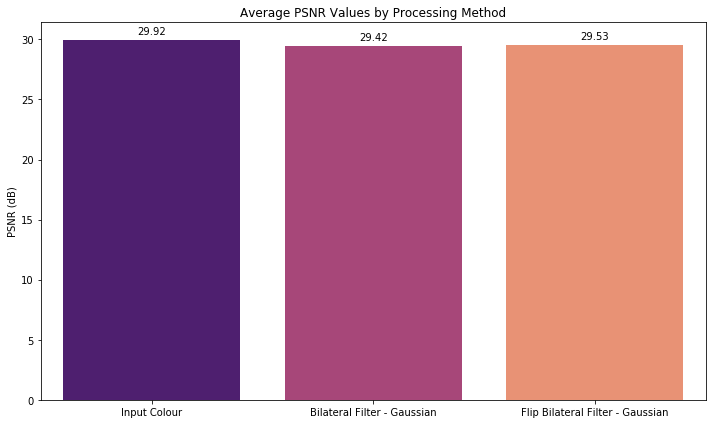

In [22]:
# Analyzing the results

original_dir_flip = r"C:\Users\dines\Desktop\dataset_one_flip"
original_dir = r"C:\Users\dines\Desktop\dataset_one"
input_colour_dir = r'C:\Users\dines\Desktop\small_set_colour'
bilateral_gaussian_dir=r'C:\Users\dines\Desktop\small_set_bilateral_gaussian_color'
flip_bilateral_gaussian_dir=r'C:\Users\dines\Desktop\small_set_custom_colour'
output_csv_path = r"C:\Users\dines\Desktop\p_2_comparison_results.csv"
img_psnr_path = r"C:\Users\dines\Desktop\p_2_psnr.png"
img_ssim_path = r"C:\Users\dines\Desktop\p_2_ssim.png"

analyze(original_dir, original_dir_flip, input_colour_dir, bilateral_gaussian_dir, flip_bilateral_gaussian_dir, output_csv_path, img_psnr_path, img_ssim_path)


In [34]:
output_csv_path = r"C:\Users\dines\Desktop\p_2_comparison_results.csv"

In [35]:
import pandas as pd

data = pd.read_csv(output_csv_path)

print("Image Comparison Results:")
print(data.to_string(index=False))


Image Comparison Results:
             Image  SSIM_Input_Colour  PSNR_Input_Colour  SSIM_Bilateral_Gaussian  PSNR_Bilateral_Gaussian  SSIM_Flip_Bilateral_Gaussian  PSNR_Flip_Bilateral_Gaussian
  old_photo_01.jpg           0.957200          30.259678                 0.950150                29.634088                      0.953932                     29.838357
  old_photo_02.jpg           0.936298          29.172695                 0.922038                28.867260                      0.928888                     29.924649
  old_photo_03.jpg           0.937317          29.726730                 0.919939                29.529217                      0.923214                     29.470305
  old_photo_04.jpg           0.956937          31.553182                 0.946391                30.560664                      0.942721                     29.098505
  old_photo_05.jpg           0.973646          30.514108                 0.837060                29.364375                      0.827532   